In [2]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem.Scaffolds import MurckoScaffold
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from umap import UMAP

sns.set_style("darkgrid",
              {"axes.facecolor": ".95",
               "axes.edgecolor": "#000000",
               "grid.color": "#EBEBE7",
               "font.family": "serif",
               "axes.labelcolor": "#000000",
               "xtick.color": "#000000",
               "ytick.color": "#000000",
               "grid.alpha": 0.4 })
sns.set_palette('muted')

/home/wvir/miniconda3/envs/mfal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Experimental dataset

In [3]:
experimental_df = pd.read_csv('../../data/results_benchmark.csv')

scores = ['exp_dg', 'vina_score_blind', 'mmgbsa_score_blind']

In [4]:
# Quick look at data
print("Dataset shape:", experimental_df.shape)
print("\nColumn names:")
print(experimental_df.columns.tolist())
print("\nFirst few rows:")
print(experimental_df.head())

# Check for missing values
print("\nMissing values:")
print(experimental_df[scores].isnull().sum())

# Basic stats
print("\nStats (experimental dG, vina, mmgbsa):")
print(experimental_df[scores].describe())

Dataset shape: (25, 7)

Column names:
['name', 'smiles', 'exp_dg', 'exp_dg_error', 'vina_score_blind', 'mmgbsa_score_blind', 'mmgbsa_score_blind_sem']

First few rows:
     name                                             smiles    exp_dg  \
0  lig_27  [H]c1c(c(c(c(c1[H])[H])OC([H])([H])C([H])([H])... -6.116712   
1  lig_28  [H]c1c(c(c2c(c1[H])C(=C(N2[H])C(=O)[O-])C([H])... -6.621838   
2  lig_30  [H]c1c(c(c2c(c1[H])C(=C(N2[H])C(=O)[O-])C([H])... -7.853624   
3  lig_31  [H]c1c(c(c2c(c1[H])C(=C(N2[H])C(=O)[O-])C([H])... -7.919932   
4  lig_32  [H]c1c(c(c2c(c1[H])C(=C(N2[H])C(=O)[O-])C([H])... -6.583362   

   exp_dg_error  vina_score_blind  mmgbsa_score_blind  mmgbsa_score_blind_sem  
0      0.120936            -9.158          -34.132755                0.688380  
1      0.027821            -9.659          -39.792497                0.408852  
2      0.188261            -9.501          -34.901277                0.493050  
3      0.028055           -10.423          -42.650132              

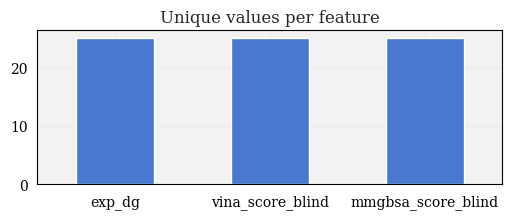

In [5]:
# Compute number of unique entries for each score type (exp_dg, vina, mmgbsa)
unique_values = experimental_df[scores].nunique().sort_values()

# Plot information
unique_values.plot.bar(figsize=(6, 2), rot=0, title="Unique values per feature");

# Computational dataset - basic stats

In [6]:
df = pd.read_csv('../../data/results.csv')

# Add molecular weight to DF
smiles = df['prot_smiles'].tolist()
mols = [Chem.MolFromSmiles(s) for s in smiles]
df['MW'] = [MolWt(m) for m in mols]

vars = ['vina_score', 'mmgbsa_score', 'MW']

In [7]:
# Quick look at data
print("Dataset shape:", df.shape)
print("\nFull dataframe column names:")
print(df.columns.tolist())
print("\nFirst few rows (scores_df):")
print(df[vars].head())

# Check for missing values
print("\nMissing values:")
print(df[vars].isnull().sum())

# Basic stats
print("\nStats (vina, mmgbsa):")
print(df[vars].describe())

Dataset shape: (59356, 9)

Full dataframe column names:
['name', 'orig_smiles', 'prot_smiles', 'mmgbsa_score', 'mmgbsa_score_sem', 'mmpbsa_score', 'mmpbsa_score_sem', 'vina_score', 'MW']

First few rows (scores_df):
   vina_score  mmgbsa_score       MW
0      -8.206    -54.684265  463.284
1      -9.915    -53.876397  442.353
2      -9.199    -53.526174  462.727
3      -8.151    -52.599412  512.198
4      -9.343    -52.518792  454.408

Missing values:
vina_score      0
mmgbsa_score    0
MW              0
dtype: int64

Stats (vina, mmgbsa):
         vina_score  mmgbsa_score            MW
count  59356.000000  59356.000000  59356.000000
mean      -8.348716    -30.718233    354.837185
std        0.923549      6.188770     67.704759
min      -11.909000    -54.684265    145.161000
25%       -9.096000    -34.814104    305.376250
50%       -8.257000    -31.103042    357.494000
75%       -7.633000    -27.031946    405.296000
max       -5.257000      3.037913    687.497000


Number of unique values: vina_score       4546
MW              13420
mmgbsa_score    59356
dtype: int64


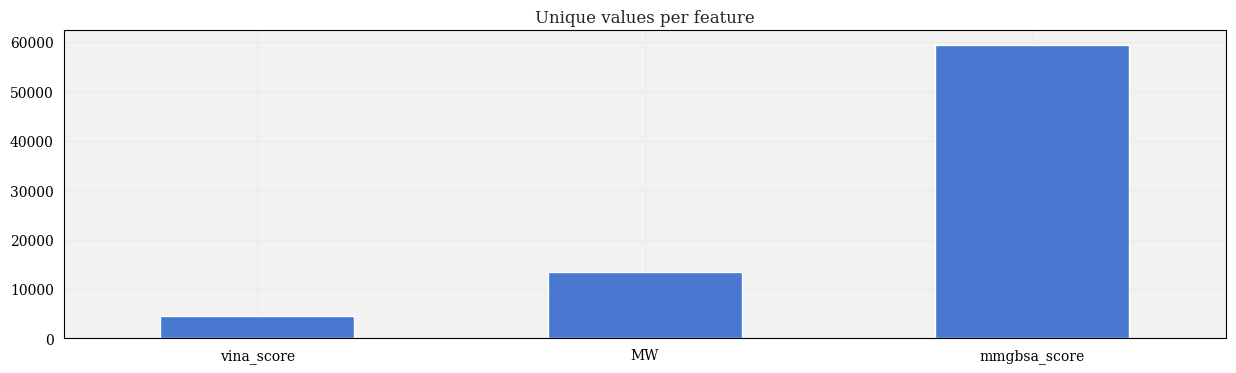

In [8]:
# Compute number of unique entries for each score type (exp_dg, vina, mmgbsa)
unique_values = df[vars].nunique().sort_values()

print("Number of unique values:", unique_values)

# Plot information
unique_values.plot.bar(figsize=(15, 4), rot=0, title="Unique values per feature");

# Visualizing distributions

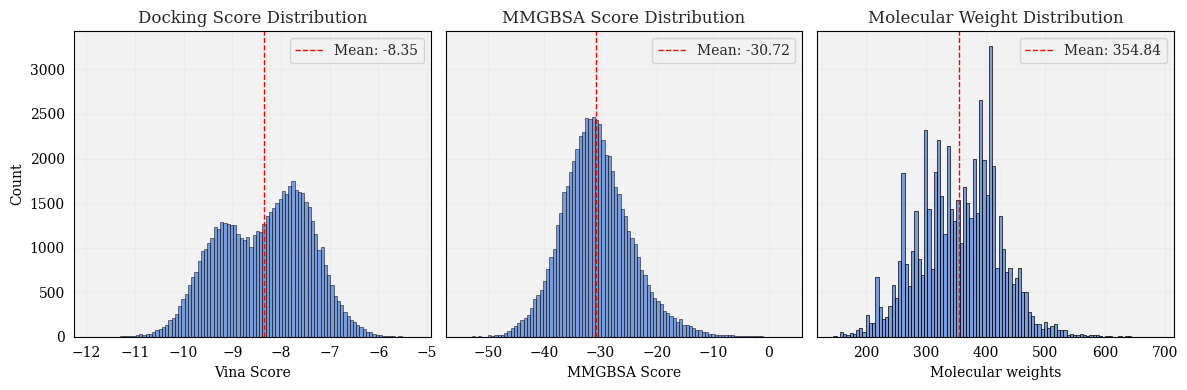

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# Vina distribution
axes[0].hist(df['vina_score'], bins=100, edgecolor='black', linewidth=.5, alpha=0.7)
axes[0].set_xlabel('Vina Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Docking Score Distribution')
axes[0].axvline(df['vina_score'].mean(), color='red', linestyle='--', lw=1, label=f'Mean: {df["vina_score"].mean():.2f}')
axes[0].legend()

# MMGBSA distribution
axes[1].hist(df['mmgbsa_score'], bins=100, edgecolor='black', linewidth=.5, alpha=0.7)
axes[1].set_xlabel('MMGBSA Score')
# axes[1].set_ylabel('Count')
axes[1].set_title('MMGBSA Score Distribution')
axes[1].axvline(df['mmgbsa_score'].mean(), color='red', linestyle='--', lw=1, label=f'Mean: {df["mmgbsa_score"].mean():.2f}')
axes[1].legend()

# Molecular weight distribution
axes[2] = sns.histplot(df['MW'], bins=100, edgecolor='black', linewidth=.5, alpha=0.7)
axes[2].set_xlabel('Molecular weights')
# axes[2].set_ylabel('Count')
axes[2].set_title('Molecular Weight Distribution')
axes[2].axvline(df['MW'].mean(), color='red', linestyle='--', lw=1, label=f"Mean: {df['MW'].mean():.2f}")
axes[2].legend()

plt.tight_layout()
plt.show()

# Correlations between features

In [10]:
def make_correlation_plot(x,y, xlabel, ylabel, title,
                          ax=None,
                          line=True,
                          show_marginals=False,
                          alpha=0.3,
                          s=10,
                          color='midnightblue',
                          marker='.',
                          figsize=(8,8)):
    """
    Make correlation plot.
    """
    
    # Compute correlations
    pearson_r, pearson_p = stats.pearsonr(x, y)
    spearman_r, spearman_p = stats.spearmanr(x, y)

    if show_marginals:
        g = sns.JointGrid(x=x, y=y, height=figsize[0])

        # Main scatter plot
        ax.ax_joint.scatter(x, y, alpha=alpha, s=s, color=color, marker=marker, edgecolors='none')

        # Add regression line
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        x_line = np.linspace(x.min(), x.max(), 100)
        stats_label = (f"Pearson r = {pearson_r:.3f}\n"
                       "Spearman " + r"$\rho$" + f" = {spearman_r:.3f}")
        g.ax_joint.plot(x_line, p(x_line), 'r-', alpha=0.7, linewidth=1.5, label=stats_label)
    
        # Marginal histograms
        g.ax_marg_x.hist(x, bins=100, alpha=0.7, edgecolor='black')
        g.ax_marg_y.hist(y, bins=100, alpha=0.7, orientation='horizontal', edgecolor='black')

        # Labels and title
        g.ax_joint.set_xlabel(xlabel, fontsize=12)
        g.ax_joint.set_ylabel(ylabel, fontsize=12)
        g.fig.suptitle(title, fontsize=14, y=.98)
        g.ax_joint.legend(bbox_to_anchor=(0.65, -.1))

        return g
    
    else:
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)

        # Scatter plot
        ax.scatter(x, y, alpha=alpha, s=s, color=color, marker=marker, edgecolors='none')

        # Add regression line
        if line:
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            x_line = np.linspace(x.min(), x.max(), 100)
            stats_label = (f"Pearson r = {pearson_r:.3f}\n"
                        "Spearman " + r"$\rho$" + f" = {spearman_r:.3f}")
            ax.plot(x_line, p(x_line), 'r-', alpha=0.7, linewidth=1.5, label=stats_label)

        # Labels and title
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_title(title, fontsize=13)
        ax.legend(loc='lower right', fontsize=9)

        return ax

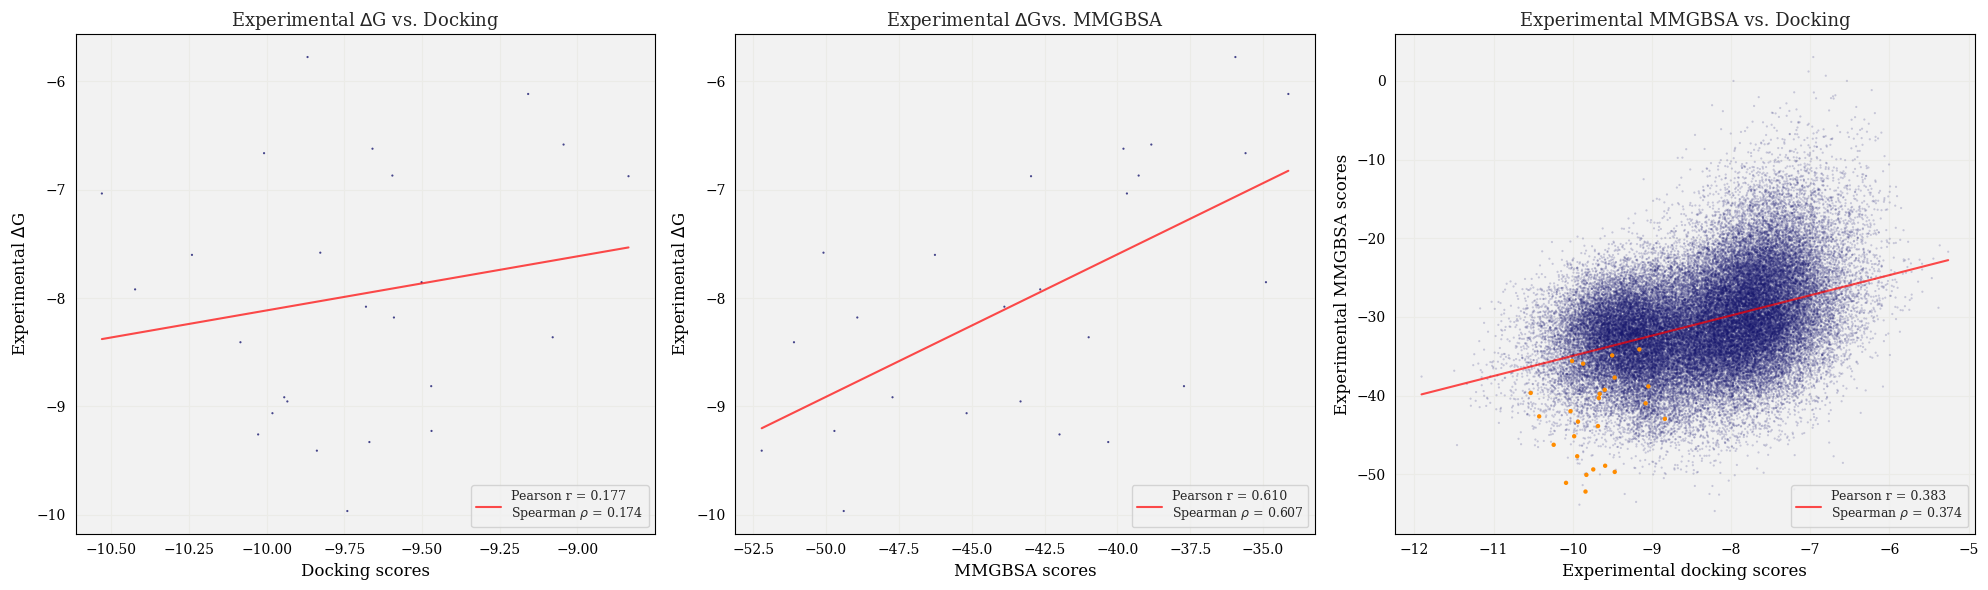

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Docking vs. experimental dG
make_correlation_plot(
    experimental_df['vina_score_blind'],
    experimental_df['exp_dg'],
    xlabel='Docking scores',
    ylabel=r'Experimental $\Delta$G',
    title=r'Experimental $\Delta$G vs. Docking',
    ax=axes[0],
    show_marginals=False,
    alpha=0.8,
)

# MMGBSA vs. experimental dG
make_correlation_plot(
    experimental_df['mmgbsa_score_blind'],
    experimental_df['exp_dg'],
    xlabel='MMGBSA scores',
    ylabel=r'Experimental $\Delta$G',
    title=r'Experimental $\Delta$Gvs. MMGBSA',
    ax=axes[1],
    show_marginals=False,
    alpha=0.8,
)

# Docking vs. MMGBSA
make_correlation_plot(
    df['vina_score'],
    df['mmgbsa_score'],
    xlabel='Docking scores',
    ylabel='MMGBSA scores',
    title='MMGBSA vs. Docking',
    ax=axes[2],
    show_marginals=False,
    alpha=0.2,
)

# Experimental docking vs. MMGBSA
make_correlation_plot(
    experimental_df['vina_score_blind'],
    experimental_df['mmgbsa_score_blind'],
    xlabel='Experimental docking scores',
    ylabel='Experimental MMGBSA scores',
    title='Experimental MMGBSA vs. Docking',
    ax=axes[2],
    line=False,
    show_marginals=False,
    alpha=1.0,
    color='darkorange',
    marker='o'
)

plt.tight_layout()
plt.show();

# Analyzing molecular structures

In [12]:
def get_scaffold(smiles):
    """Extract Bemis-Murcko scaffold from SMILES"""
    mol = Chem.MolFromSmiles(smiles)
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaffold)

In [13]:
# Extract scaffolds for all molecules
print("Extracting scaffolds from SMILES...")
df['scaffold'] = df['prot_smiles'].apply(get_scaffold)

scaffold_counts = Counter(df['scaffold'])
print(f"\nNumber of unique scaffolds:", len(scaffold_counts))
print(f"\nTop 10 most common scaffolds:")
for scaffold, count in scaffold_counts.most_common(10):
    print(f"{count:5d} molecules: {scaffold[:30]}...")

Extracting scaffolds from SMILES...

Number of unique scaffolds: 4326

Top 10 most common scaffolds:
16388 molecules: c1ccc2[nH]ccc2c1...
 8126 molecules: O=C(CCc1c[nH]c2ccccc12)Oc1cccc...
 2630 molecules: O=C(CCc1c[nH]c2ccccc12)OC1CCCC...
 1179 molecules: O=C(CCc1cc[nH]c1)Oc1ccccc1...
  930 molecules: O=C(CCc1c(-c2ccccc2)[nH]c2cccc...
  830 molecules: O=C(OCc1ccccc1)c1cc2ccccc2[nH]...
  734 molecules: O=C(CCc1c(-c2ccccc2)[nH]c2cccc...
  673 molecules: O=C(COc1ccccc1)C(=O)c1c[nH]c2c...
  522 molecules: O=C(CCc1cc[nH]c1)OC1CCCCC1...
  505 molecules: O=C(COc1ccccc1)CC12CC3CC(CC(C3...


I'm going to visualize the top 5 most common scaffolds, along with the *query molecule*, i.e., the molecule that was used as the seed for screening. 

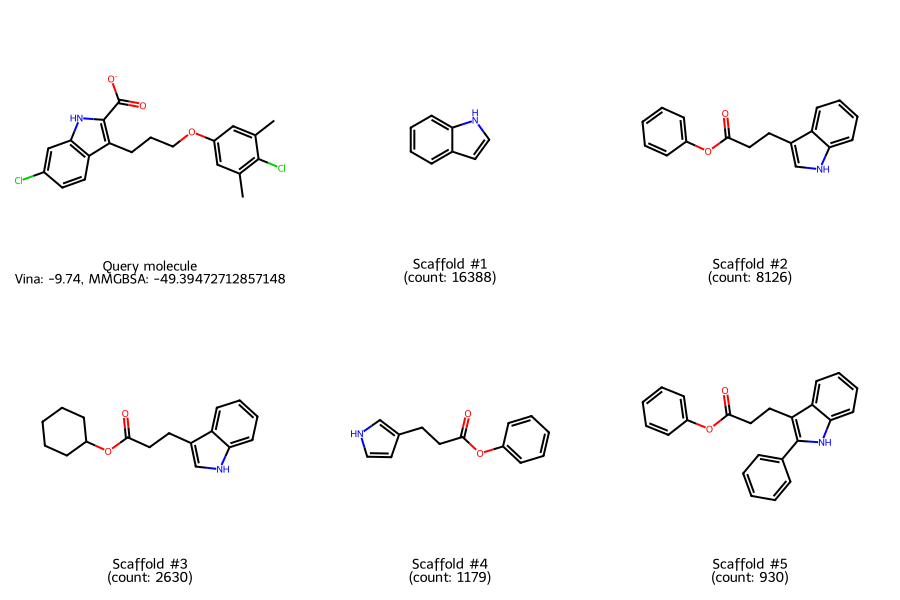

In [14]:
mols_to_draw = []
legends = []

# Get seed molecule from experimental dataset - this is molecule with best binding affinity
best_mol_idx = experimental_df['exp_dg'].idxmin()
query_molecule = experimental_df.loc[best_mol_idx]
query_mol = Chem.MolFromSmiles(query_molecule['smiles'])
mols_to_draw.append(query_mol)
legends.append(f"Query molecule\nVina: {query_molecule['vina_score_blind']}, MMGBSA: {query_molecule['mmgbsa_score_blind']}")

# Get 5 most common scaffolds
top_5_scaffolds = [scaffold for scaffold, _ in scaffold_counts.most_common(5)]
for i, scaffold_smiles in enumerate(top_5_scaffolds, 1):
    scaffold_mol = Chem.MolFromSmiles(scaffold_smiles)
    mols_to_draw.append(scaffold_mol)
    count = scaffold_counts[scaffold_smiles]
    legends.append(f"Scaffold #{i}\n(count: {count})")

img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=3, subImgSize=(300, 300), legends=legends, returnPNG=False)
display(img);

How much of the dataset do these scaffolds account for?

In [17]:
print(f"Coverage of top 5 scaffolds: {100 * sum(sorted(scaffold_counts.values(), reverse=True)[:5]) / len(df):.3f}%")

Coverage of top 5 scaffolds: 49.284%


# Clustering

Now I'll do clustering based on structural similarity. To do so, I'll use the `pyclustering` module. This involves choosing initial values for the $k$ medoids, for which I'll choose different scaffolds that are far apart.

In [18]:
# Compute ECFP4 fingerprints:
def smiles_to_fp(smiles):
    # Return fingerprint as numpy array
    mol = Chem.MolFromSmiles(smiles)
    fp_gen = Chem.rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
    return fp_gen.GetCountFingerprintAsNumPy(mol)

df['fp'] = df['prot_smiles'].apply(smiles_to_fp)

In [19]:
unique_scaffolds = df['scaffold'].unique()
X = np.stack([smiles_to_fp(scaffold) for scaffold in unique_scaffolds])

## Determining optimal cluster number via silhouette score

In [20]:
cluster_range = range(5,25)
score_list = []
for k in cluster_range:
    km = KMeans(n_clusters=k,random_state=42,n_init='auto')
    cluster_labels = km.fit_predict(X)
    score = silhouette_score(X,cluster_labels)
    score_list.append([k,score])

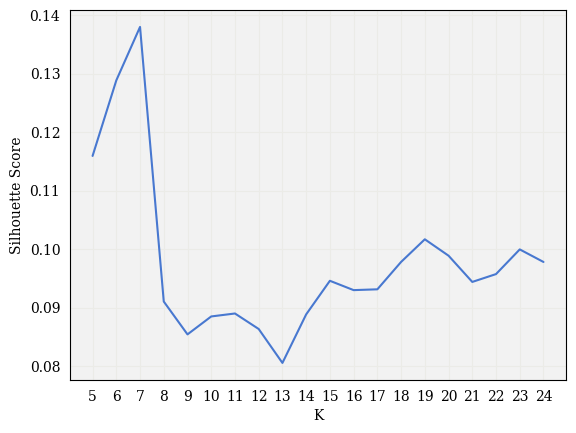

In [21]:
score_df = pd.DataFrame(score_list,columns=["K","Silhouette Score"])
ax = sns.lineplot(x="K",y="Silhouette Score",data=score_df)
ax.set_xticks(cluster_range);

In [25]:
num_clusters = 7
km = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
km.fit(X)
cluster_list = km.predict(X)

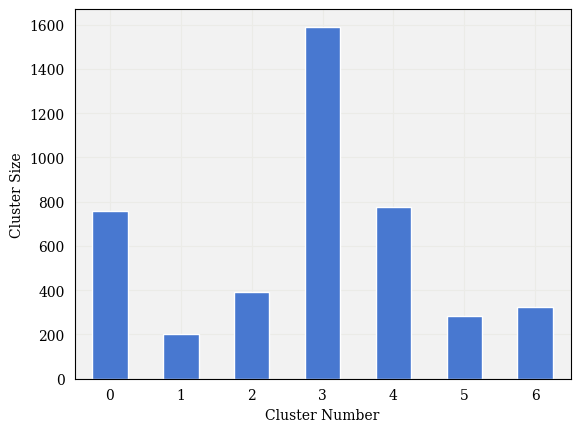

In [26]:
ax = pd.Series(cluster_list).value_counts().sort_index().plot(kind="bar")
ax.set_xlabel("Cluster Number")
ax.set_ylabel("Cluster Size")
ax.tick_params(axis='x', rotation=0)

## Visualizing cluster

Here, I'll perform t-SNE / UMAP to look at three things:

1. How distinct the clusters are (for this, I'll do UMAP and color the points based on cluster)
2. How much clusters correspond to docking scores (coloring by docking scores)
3. How much clusters correspond to MMGBSA scores (coloring by MMGBSA scores)

This is ultimately to better understand what information the models are using to predict docking scores and MMGBSA scores. I expect that the docking scores largely depend on molecular structure and molecular weight. We already saw that the two distributions share the same biomodal shape. So, I expect that docking scores can be predicted reasonably well by scaffold. That is, docking scores largely depend on the structure of the molecule.

I expect that, since MMGBSA has proven to be harder to learn, then predicting this from structure alone is difficult for current ML models. So, I expect that the MMGBSA scores will not correspond as closely to the structural clusters as do the docking scores. This would indicate that the MD simulations capture more nuanced information than just molecular structure. Thus, when we train models to predict MMGBSA scores from molecular structure alone, they struggle.

First, I'm just going to cluster the scaffolds.

In [27]:
scaffold_to_cluster = dict(zip(unique_scaffolds, cluster_list))
df['Cluster'] = df['scaffold'].map(scaffold_to_cluster)

In [29]:
tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
coords = tsne.fit_transform(X, cluster_list)

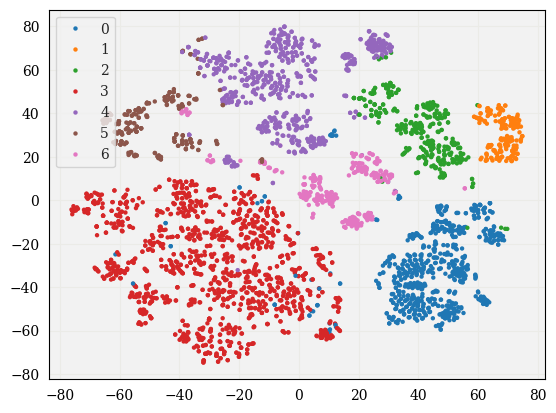

In [32]:
ax = sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=cluster_list, palette='tab10', s=10, edgecolor='none')

Now, I'll cluster the molecular fingerprints of the entire dataset, and color the plot based on scaffold cluster number.

In [33]:
X = np.stack(df.fp)

In [35]:
tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
coords = tsne.fit_transform(X, df['Cluster'])

In [36]:
df['tsne_x'] = coords[:,0]
df['tsne_y'] = coords[:, 1]
df.to_csv('df_cluster.csv')

In [97]:
def plot_scaffold_clusters(df, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    
    sns.scatterplot(ax=ax, x=df['tsne_x'], y=df['tsne_y'], hue=df['Cluster'], palette='tab10', s=10, edgecolor='none')

    ax.set_aspect('equal')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title('Scaffold clusters', fontsize=14)
    
    ax.legend().remove()
    
    return ax

def create_quantile_bins(scores, quantiles=[0.01, 0.05, 0.10, 0.25]):
    """
    Bin scores into quantile groups
    """

    # Compute quantile thresholds
    thresholds = np.quantile(scores, quantiles)

    # Create bins
    bins = []
    labels = []

    # Best bin (top 1%)
    labels.append(f'Top 1%')

    # Intermediate bins
    for i in range(len(quantiles) - 1):
        pct1 = int(quantiles[i] * 100)
        pct2 = int(quantiles[i+1] * 100)
        labels.append(f'Top {pct1}-{pct2}%')
    
    # Remaining
    labels.append(f'Rest (>{int(quantiles[-1]*100)}%)')

    # Assign molecules to bins
    binned = np.full(len(scores), labels[-1], dtype=object)

    # Work backwards from lowest threshold
    for i in range(len(thresholds)-1, -1, -1):
        # If the score is less than the given threshold (lower is better),
        # assign it to lower bin
        binned[scores <= thresholds[i]] = labels[i]

    binned = pd.Categorical(binned, categories=labels, ordered=True)

    return binned


def plot_score_quantiles(df, score_col, title, ax=None,
                         quantiles=[0.01, 0.05, 0.10, 0.25],
                         figsize=(10, 8), s=10, alpha=0.6):
    """
    Plot t-SNE with scores binned into quantiles.
    """
    df_plot = df.copy()
    df_plot['score_bin'] = create_quantile_bins(df[score_col], quantiles)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    palette = sns.color_palette("Blues_r", n_colors=len(quantiles)+1)

    # Plot in reverse order so best binders are on top
    for category in reversed(df_plot['score_bin'].cat.categories):
        mask = df_plot['score_bin'] == category
        ax.scatter(
            df_plot.loc[mask, 'tsne_x'],
            df_plot.loc[mask, 'tsne_y'],
            c=[palette[df_plot['score_bin'].cat.categories.get_loc(category)]],
            label=category,
            s=s,
            alpha=alpha,
            edgecolors='none'
        )
    
    # ax.set_xlabel('t-SNE 1', fontsize=12)
    # ax.set_ylabel('t-SNE 2', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_aspect('equal')

    return ax

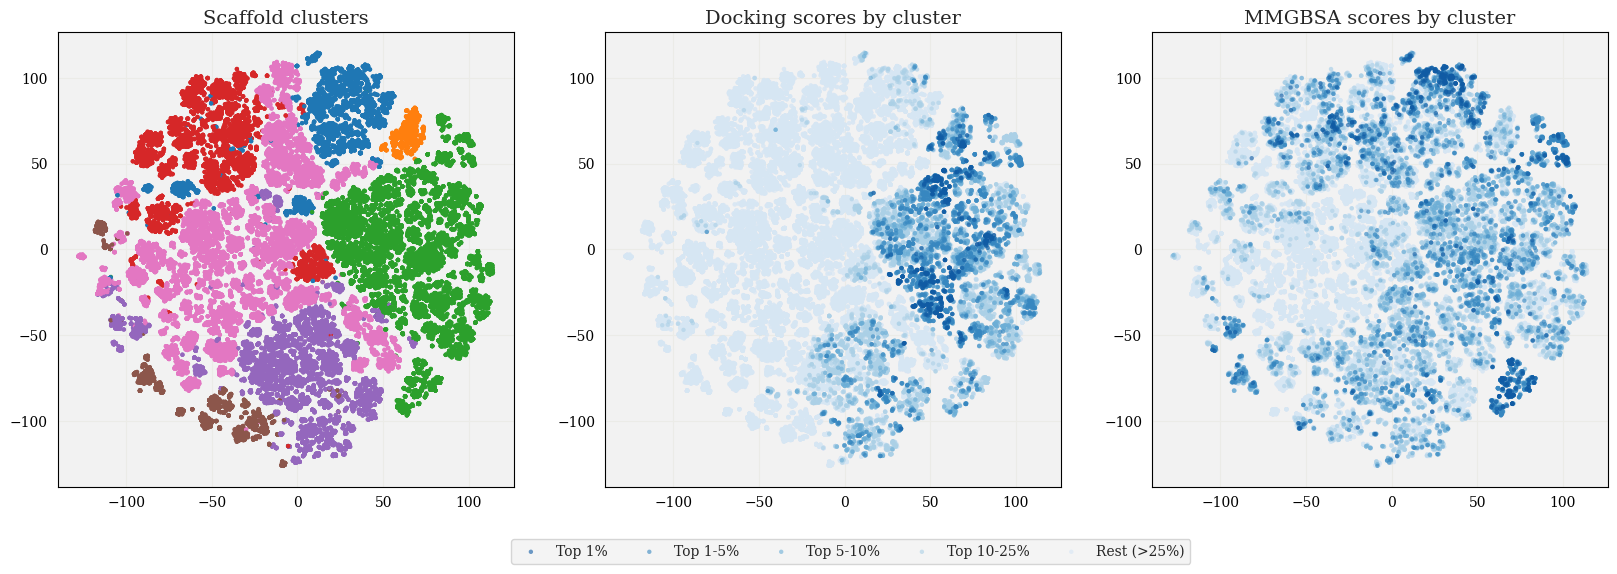

In [102]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

plot_scaffold_clusters(df, ax=axes[0])

plot_score_quantiles(
    df,
    'vina_score',
    title='Docking scores by cluster',
    ax=axes[1]
)

plot_score_quantiles(
    df,
    'mmgbsa_score',
    title='MMGBSA scores by cluster',
    ax=axes[2]
)

axes[2].legend(bbox_to_anchor=(0.1, -.1), ncols=5, reverse=True);